<AxesSubplot:xlabel='Count', ylabel='category'>

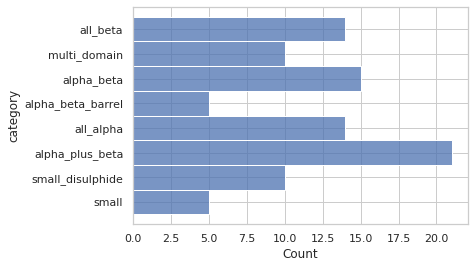

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import glob 
import matplotlib.pyplot as plt
import matplotlib as mpl

sns.set_context("talk")
data_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/"

sns.set_theme(style="whitegrid")

# load families summary
summary_homfam_exthomfam = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/01_summary_homfam_exthomfam.csv")
summary_homfam = summary_homfam_exthomfam[summary_homfam_exthomfam.dataset == "homfam"]
families = summary_homfam.drop(["subset", "file", "min_length", "max_length", "perc_ref_total", "dataset"], axis = 1)

# Load similarities 
evaluation_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/"
sims = os.path.join(evaluation_dir,"homfam/evaluation/sim/*FAMSA.MBED.sim")
sim_df = pd.DataFrame()
for file in list(glob.glob(sims)):
    full_name = file.split(sep = "/")[-1].replace(".sim", "")
    file_opened = open(file, "r")
    tot_line = [line.split() for line in file_opened if line.startswith('TOT')]
    entry = pd.DataFrame({'name': [full_name],"sim_tot": tot_line[0][3]})
    sim_df =  pd.concat([sim_df, entry], ignore_index = True)

    
sim_df["family"] = sim_df.name.str.split(".", expand = True)[0]
sim_df["family"] = sim_df.family.str.replace("-ref", "")
sim_df = sim_df.rename(columns = {"sim_tot": "sim"})
families = pd.merge(families,sim_df)
families["family_real"]= families.family
families["family"] = families.family_real+"-ref"
families = families.drop(["family_real", "name"], axis = 1)
families["sim"] = families.sim.astype(float)

# 1. PREP SCORES
def get_scores(score_files): 
    def parse_score(score_file): 
        return(pd.read_csv(score_file,sep = ";", header = None).drop(4, axis = 1))

    scores = pd.concat(list(map(parse_score, score_files)))
    scores = scores.iloc[:,0:4]
    scores.columns = ['name', 'sp', 'tc', 'column']
    return(scores)


def plot_scatter_perc(df1,df2,xlabel,ylabel,
                      palette = sns.dark_palette("#3399FF", reverse = True, as_cmap=True),
                      log = True, 
                      title = "regressive on homfam", hue_var = "sim", metric = "tc", size_fig = 1): 
    f, ax = plt.subplots(figsize=(8*size_fig,6.4*size_fig ))
    
    # Prep df 
    df = df1.merge(df2, on = ["family", hue_var])
    
    
    hue = df[hue_var]
    # colorbar 
    norm = mpl.colors.Normalize( vmin=0, vmax=100)
    sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
    sm.set_array([])
    
    # Color bar 
    cbar =ax.figure.colorbar(sm, ticks=[0,50,100], format=mpl.ticker.ScalarFormatter())
    cbar.ax.set_yticklabels(["0", "50", "100"]) 
    cbar.ax.set_ylabel('avg % similarity', rotation=270, labelpad = 20, fontsize = "small")
    
    metric_x = metric+"_x"
    metric_y = metric+"_y"
    # Plot 
    ax = sns.scatterplot(data = df, x = metric_x,
                    y = metric_y,
                    hue = hue_var,
                    s = 100,
                    palette = palette)

    # % above the line
    perc_y_better_than_x = (len(list(filter(lambda ele: ele == True, list(df[metric_x] <= df[metric_y])))) / len(list(df[metric_x]  >= df[metric_y] ))) * 100
    
    # Diagonal line
    ax.axline((1, 1), slope=1, ls="--", c=".2", lw = 0.8)
    
    ax.set(xlim = (0,100), ylim = (0,100))
    ax.get_legend().remove()
    
    # Axis labels
    ax.set(xlabel=xlabel,
           ylabel=ylabel,
           title = title + "\n metric: "+metric+"\n (n = "+str(len(df[metric_x] ))+") \n\n % y >= x  "+str(round(perc_y_better_than_x,1))+" \n")




def get_traces(traces): 
    def parse_trace(trace):
        dataset = os.path.dirname(trace).split("/")[-3]
        family = os.path.dirname(trace).split("/")[-1]
        df = pd.read_csv(trace, sep = "=").T
        df["dataset"] = dataset
        df["family"] = family
        return(df.reset_index())

    traces = pd.concat(list(map(parse_trace, traces)))
    return(traces)

# Categories
categories_file = "/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam/metadata/categories_learnMSA.txt"
categories = pd.read_csv(categories_file, sep =" ", header =None)
categories.columns = ["family", "category", "n"]
sns.histplot(categories, y = "category")

In [2]:
#families.to_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/01_summary_families_sim.csv", index = False)

In [2]:
summary_homfam_exthomfam.sort_values("n_sequences", ascending = False)

,family,subset,n_sequences,mean_length,min_length,max_length,file,size_group,perc_ref_total,dataset
464,ABC_tran,combined,2606818,167.505647,18,2239,ABC_tran,huge,0.000230,extHomfam_v35-uniprot
469,response_reg,combined,1238401,109.446430,28,156,response_reg,huge,0.001050,extHomfam_v35-uniprot
465,HATPase_c,combined,1002802,110.293017,27,287,HATPase_c,huge,0.000598,extHomfam_v35-uniprot
472,helicase_NC,combined,842157,129.295910,19,848,helicase_NC,huge,0.000356,extHomfam_v35-uniprot
466,mdd,combined,824250,116.826655,21,387,mdd,huge,0.000364,extHomfam_v35-uniprot
...,...,...,...,...,...,...,...,...,...,...
121,thionin,combined,268,43.604478,21,49,thionin,small,1.119403,extHomfam_v35-uniprot
100,toxin_2,combined,223,31.417040,18,40,toxin_2,small,9.417040,extHomfam_v35-uniprot
111,neurotox,combined,205,30.995122,18,36,neurotox,small,1.463415,extHomfam_v35-uniprot
92,hip,combined,167,66.209581,54,85,hip,small,2.994012,homfam


In [3]:
summary_homfam[summary_homfam.family.isin(["cah", "hip", "aldosered"])]

,family,subset,n_sequences,mean_length,min_length,max_length,file,size_group,perc_ref_total,dataset
13,aldosered,combined,13277,268.547187,32,453,aldosered,large,0.052723,homfam
68,cah,combined,1379,212.705584,23,279,cah,small,0.362582,homfam
92,hip,combined,167,66.209581,54,85,hip,small,2.994012,homfam


In [17]:
# 0. GET RUNNING TIME LIBRARIES
trace_files = (glob.glob(os.path.join(data_dir, "libraries/*/*/*/.command.trace")))
traces_df = get_traces(trace_files)
traces_df["running_time (s)"] = traces_df.realtime/1000


# subselect where there are the 3 of them 
filter_traces =  traces_df[traces_df.family.isin(set(traces_df[traces_df.dataset == "TMalign_pair"].family))]
filter_traces["dataset"] = filter_traces.dataset.str.replace("foldseek", "3Di")
filter_traces["dataset"] = pd.Categorical(filter_traces.dataset, ["sequence", "3Di", "TMalign_pair"])

0        sap_pair
0        sap_pair
0        sap_pair
0        sap_pair
0        sap_pair
         ...     
0    TMalign_pair
0    TMalign_pair
0    TMalign_pair
0    TMalign_pair
0    TMalign_pair
Name: dataset, Length: 377, dtype: object

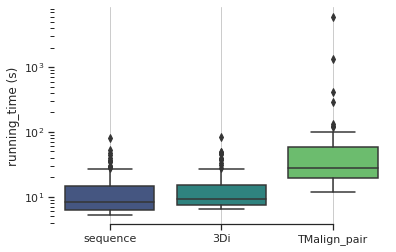

In [22]:

sns.set_context("talk")

sns.set_theme(style="white")
# PLOT RUNNING TIME LIBRARIES
sns.set_theme(style="ticks")
# Add at least 1 second for plotting
filter_traces["running_time (s)"] = filter_traces["running_time (s)"]+1
ax = sns.boxplot(data = filter_traces, x = "dataset", y = "running_time (s)",palette="viridis" )
plt.yscale('log')

ax.xaxis.grid(True)
ax.set(xlabel="")
sns.despine(trim=True, left=True)

## COLLECT SCORES 

In [6]:
# 1. SEQUENCE  
#sequence_scores = get_scores(glob.glob(os.path.join(data_dir, "evaluation/score/*progressive.PROBAPAIR.MBED*")))
sequence_scores = get_scores(glob.glob(os.path.join(data_dir, "evaluation/score/*sequence_only*")))
sequence_scores[["family", "method", "tree_method","library_method"]] = sequence_scores.name.str.split(".", expand = True)
sequence_scores = pd.merge(sequence_scores, families, on = "family")

# 2. FOLDSEEK  
foldseek_scores = get_scores(glob.glob(os.path.join(data_dir, "evaluation/score/*foldseek_only*")))
foldseek_scores[["family", "align_method", "tree_method", "library_method"]] = foldseek_scores.name.str.split(".", expand = True)
foldseek_scores = pd.merge(foldseek_scores, families, on = "family")

# 3. FOLDSEEK_SEQUENCE
foldseek_sequence_scores = get_scores(glob.glob(os.path.join(data_dir, "evaluation/score/*foldseek_sequence*")))
foldseek_sequence_scores[["family", "align_method", "tree_method", "library_method"]] = foldseek_sequence_scores.name.str.split(".", expand = True)
foldseek_sequence_scores = pd.merge(foldseek_sequence_scores, families, on = "family")

# 4. TMALIGN
tmalign_scores = get_scores(glob.glob(os.path.join(data_dir, "evaluation/score/*tmalign_only*")))
tmalign_scores[["family", "method", "tree_method","library_method"]] = tmalign_scores.name.str.split(".", expand = True)
tmalign_scores = pd.merge(tmalign_scores, families, on = "family")

# 5. TMALIGN_SEQUENCE
tmalign_sequence_scores = get_scores(glob.glob(os.path.join(data_dir, "evaluation/score/*tmalign_sequence*")))
tmalign_sequence_scores[["family", "method", "tree_method","library_method"]] = tmalign_sequence_scores.name.str.split(".", expand = True)
tmalign_sequence_scores = pd.merge(tmalign_sequence_scores, families, on = "family")

# 6. SAP
sap_scores = get_scores(glob.glob(os.path.join(data_dir, "evaluation/score/*sap_only*")))
sap_scores[["family", "method", "align_method", "tree_method"]] = sap_scores.name.str.split(".", expand = True)
sap_scores = pd.merge(sap_scores, families, on = "family")

# 7. SAP_SEQUENCE
sap_sequence_scores = get_scores(glob.glob(os.path.join(data_dir, "evaluation/score/*sap_sequence*")))
sap_sequence_scores[["family", "method", "align_method", "tree_method"]] = sap_sequence_scores.name.str.split(".", expand = True)
sap_sequence_scores = pd.merge(sap_sequence_scores, families, on = "family")

In [7]:
fam_id = "seatoxin-ref"
print("sequence")
(sequence_scores[sequence_scores.family == fam_id])

sequence


,name,sp,tc,column,family,method,tree_method,library_method,n_sequences,mean_length,size_group,sim
86,seatoxin-ref.foldseek.MBED.sequence_only,82.9,55.1,53.7,seatoxin-ref,foldseek,MBED,sequence_only,93,43.634409,small,42.49


In [8]:
# 2. FOLDSEEK SCORES 
foldseek_scores = get_scores(glob.glob(os.path.join(data_dir, "evaluation/score/*foldseek_only*")))
foldseek_scores[["family", "align_method", "tree_method", "library_method"]] = foldseek_scores.name.str.split(".", expand = True)
foldseek_scores = pd.merge(foldseek_scores, families, on = "family")

# 3. FOLDSEEK_SEQUENCE
foldseek_sequence_scores = get_scores(glob.glob(os.path.join(data_dir, "evaluation/score/*foldseek_sequence*")))
foldseek_sequence_scores[["family", "align_method", "tree_method", "library_method"]] = foldseek_sequence_scores.name.str.split(".", expand = True)
foldseek_sequence_scores = pd.merge(foldseek_sequence_scores, families, on = "family")

In [28]:
sequence_scores.family.str.replace("-ref", "")
tmalign_scores

,name,sp,tc,column,family,method,tree_method,library_method,n_sequences,mean_length,size_group,sim
0,flav-ref.foldseek.MBED.tmalign_only,92.7,78.3,81.4,flav-ref,foldseek,MBED,tmalign_only,4612,138.021032,medium,35.04
1,hla-ref.foldseek.MBED.tmalign_only,100.0,100.0,100.0,hla-ref,foldseek,MBED,tmalign_only,13465,153.147642,large,76.46
2,ghf11-ref.foldseek.MBED.tmalign_only,96.8,91.1,92.0,ghf11-ref,foldseek,MBED,tmalign_only,521,167.758157,small,50.02
3,sdr-ref.foldseek.MBED.tmalign_only,90.3,49.2,63.8,sdr-ref,foldseek,MBED,tmalign_only,50157,163.252547,xlarge,22.85
4,ghf13-ref.foldseek.MBED.tmalign_only,83.3,46.2,58.4,ghf13-ref,foldseek,MBED,tmalign_only,12607,264.451575,large,26.88
...,...,...,...,...,...,...,...,...,...,...,...,...
89,glob-ref.foldseek.MBED.tmalign_only,95.9,53.5,58.5,glob-ref,foldseek,MBED,tmalign_only,3983,100.683656,small,31.70
90,subt-ref.foldseek.MBED.tmalign_only,91.1,61.7,70.6,subt-ref,foldseek,MBED,tmalign_only,7517,301.597712,medium,39.78
91,ins-ref.foldseek.MBED.tmalign_only,87.8,56.5,77.9,ins-ref,foldseek,MBED,tmalign_only,793,65.282472,small,44.79
92,hr-ref.foldseek.MBED.tmalign_only,98.4,92.4,97.1,hr-ref,foldseek,MBED,tmalign_only,3707,65.151335,small,53.31


In [29]:
sequence_scores["family"] = sequence_scores.family.str.replace("-ref", "")
tmalign_scores["family"] = tmalign_scores.family.str.replace("-ref", "")

In [10]:
def plot_categories(df1,df2,categories,xlabel,ylabel, metric = "sp", size_fig = 1): 
    sns.set_context("talk")
    f, ax = plt.subplots(figsize=(8*size_fig,6.4*size_fig ))
    
    # Prep df 
    df1["family"] = df1.family.str.split("-", expand = True)[0]
    df2["family"] = df2.family.str.split("-", expand = True)[0]

    df = df1.merge(categories, on = ["family"])
    df = df.merge(df2, on = ["family"])

    metric_x = metric+"_x"
    metric_y = metric+"_y"
    # Plot 
    ax = sns.scatterplot(data = df, x = metric_x,
                    y = metric_y,
                    hue = "category",
                    s = 80)
    

    # Diagonal line
    ax.axline((1, 1), slope=1, ls="--", c=".2", lw = 0.8)
    ax.legend(bbox_to_anchor=(2, 1.05))

    # Axis limits
    plt.xlim([0, 100])
    plt.ylim([0, 100])

    
    # Axis labels
    ax.set(xlabel=xlabel,
           ylabel=ylabel)

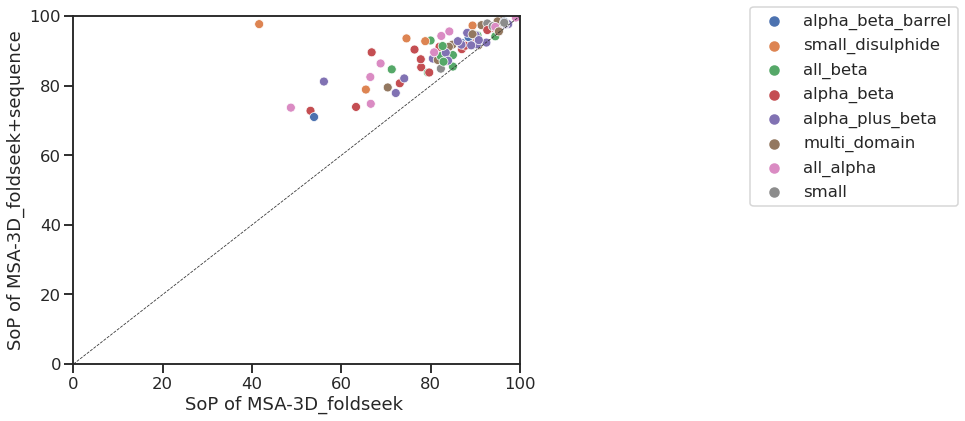

In [11]:
plot_categories(foldseek_scores,foldseek_sequence_scores,categories, "SoP of MSA-3D_foldseek ", "SoP of MSA-3D_foldseek+sequence",metric = "sp")

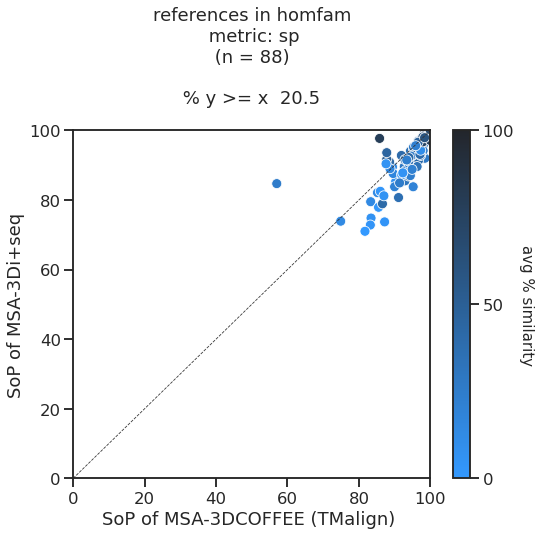

In [30]:
plot_scatter_perc(tmalign_scores,foldseek_sequence_scores, "SoP of MSA-3DCOFFEE (TMalign) ", "SoP of MSA-3Di+seq",metric = "sp", title = "references in homfam")

In [22]:
sequence_scores

,name,sp,tc,column,family,method,tree_method,library_method,n_sequences,mean_length,size_group,sim
0,OTCace-ref.foldseek.MBED.sequence_only,94.6,82.5,85.4,OTCace-ref,foldseek,MBED,sequence_only,4795,157.004588,medium,37.82
1,ghf22-ref.foldseek.MBED.sequence_only,97.5,86.9,89.3,ghf22-ref,foldseek,MBED,sequence_only,760,107.567105,small,51.78
2,ghf13-ref.foldseek.MBED.sequence_only,72.4,27.5,36.4,ghf13-ref,foldseek,MBED,sequence_only,12607,264.451575,large,26.88
3,DMRL_synthase-ref.foldseek.MBED.sequence_only,92.4,72.8,82.7,DMRL_synthase-ref,foldseek,MBED,sequence_only,2099,140.590281,small,32.25
4,bowman-ref.foldseek.MBED.sequence_only,97.7,90.0,95.9,bowman-ref,foldseek,MBED,sequence_only,499,26.144289,small,64.12
...,...,...,...,...,...,...,...,...,...,...,...,...
89,uce-ref.foldseek.MBED.sequence_only,92.5,57.8,66.8,uce-ref,foldseek,MBED,sequence_only,4558,134.700527,medium,33.47
90,gluts-ref.foldseek.MBED.sequence_only,92.5,73.0,79.7,gluts-ref,foldseek,MBED,sequence_only,10099,98.111694,large,39.50
91,scorptoxin-ref.foldseek.MBED.sequence_only,93.4,79.5,85.7,scorptoxin-ref,foldseek,MBED,sequence_only,363,53.256198,small,46.90
92,hpr-ref.foldseek.MBED.sequence_only,98.3,94.3,96.3,hpr-ref,foldseek,MBED,sequence_only,3349,83.042699,small,44.40


ZeroDivisionError: division by zero

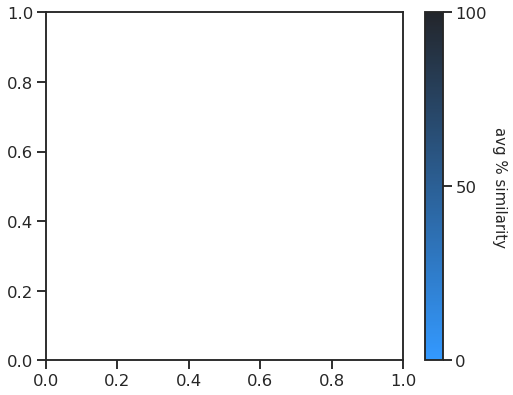

In [16]:
plot_scatter_perc(sequence_scores,foldseek_sequence_scores, "SoP of MSA-seq ", "SoP of MSA-3Di+seq",metric = "sp", title = "references in homfam")

In [8]:
scores = pd.concat([sequence_scores,foldseek_sequence_scores, foldseek_scores, tmalign_scores, tmalign_sequence_scores, sap_scores, sap_sequence_scores])
scores["library_method"] = pd.Categorical(scores.library_method, ["sequence_only", "foldseek_only", "foldseek_sequence", "tmalign_scores", "tmalign_sequence_scores","sap_scores", "sap_sequence_scores"])
scores["fam_clean"] = scores.family.str.replace("-ref", "")

In [11]:
scores[scores.family == "DEATH-ref"]

,name,sp,tc,column,family,method,tree_method,library_method,n_sequences,mean_length,size_group,sim,align_method,fam_clean
80,DEATH-ref.foldseek.MBED.sequence_only,64.8,22.6,30.7,DEATH-ref,foldseek,MBED,sequence_only,1183,80.568893,small,21.2,NaN,DEATH
47,DEATH-ref.foldseek.MBED.foldseek_sequence,73.7,35.5,47.6,DEATH-ref,NaN,MBED,foldseek_sequence,1183,80.568893,small,21.2,foldseek,DEATH
57,DEATH-ref.foldseek.MBED.foldseek_only,48.7,5.6,7.0,DEATH-ref,NaN,MBED,foldseek_only,1183,80.568893,small,21.2,foldseek,DEATH
59,DEATH-ref.foldseek.MBED.tmalign_only,87.2,54.0,73.2,DEATH-ref,foldseek,MBED,NaN,1183,80.568893,small,21.2,NaN,DEATH
84,DEATH-ref.foldseek.MBED.tmalign_sequence,75.3,34.7,47.2,DEATH-ref,foldseek,MBED,NaN,1183,80.568893,small,21.2,NaN,DEATH
37,DEATH-ref.foldseek.MBED.sap_only,95.2,79.0,86.2,DEATH-ref,foldseek,sap_only,NaN,1183,80.568893,small,21.2,MBED,DEATH
93,DEATH-ref.foldseek.MBED.sap_sequence,76.9,33.9,46.1,DEATH-ref,foldseek,sap_sequence,NaN,1183,80.568893,small,21.2,MBED,DEATH


In [16]:
scores.to_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/scores_ref_foldseek_libraries.csv", index = False)

#families.to_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/01_summary_families_sim.csv", index = False)

In [17]:
# How do we do in the families with tricky infos? 
#prob_families = 'cryst,msb,HLH,LIM,oxidored_q6,serpin,toxin,int,ins,rhv,myb_DNA-binding,hr,ChtBD,tms,bowman,mmp,tgfb,adh,phc'
#prob_families = prob_families.split(",")
#scores_prob = scores[scores.fam_clean.isin(prob_families)]

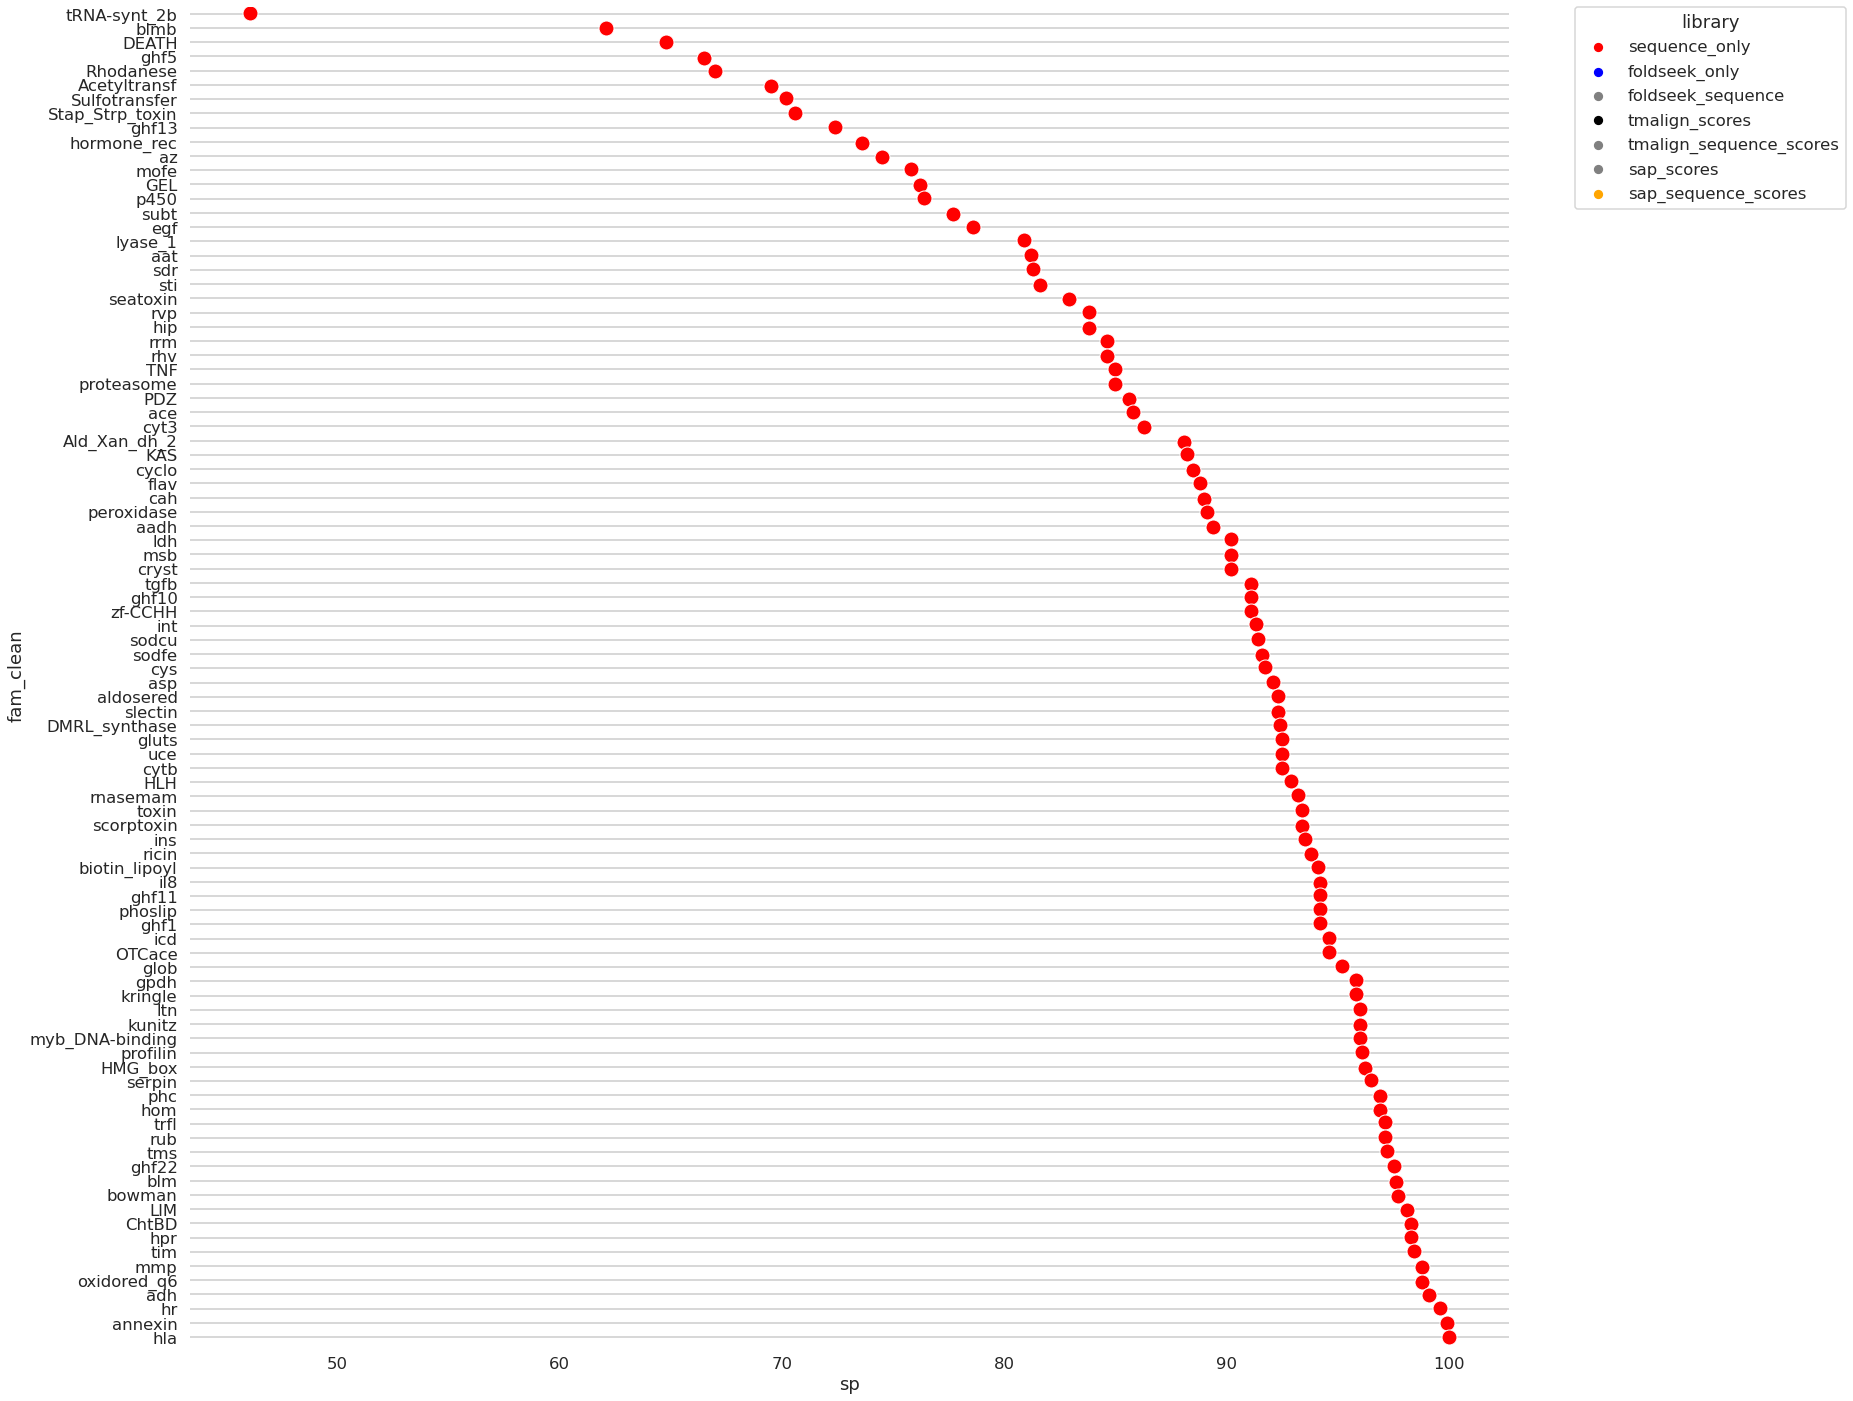

In [18]:
scores_prob=scores
# Subsetting
#scores_prob = scores_prob[scores_prob.library_method.isin(["foldseek_only", "foldseek_sequence"])]

#plot = plt.scatter(df["family"], df["corr"], c=df["sp_3D"], cmap='Reds')
#plt.clf()
#cbar = plt.colorbar(plot)
#cbar.set_label('sp_3D', rotation=270)
import itertools
sns.set_theme(style="whitegrid")
sns.set_context("talk")



sorter = scores_prob[scores_prob.library_method == "sequence_only"].sort_values("sp").family.to_frame()
scores_prob = pd.merge(sorter,scores_prob, on = "family", how = 'left')

# Create an array with the colors you want to use
colors = list(itertools.chain.from_iterable([["red", "blue", "grey", "black", "grey", "grey"],["orange"]*100]))

#colors = ["red", "blue", "grey", "black", "grey", "grey", rep(c("orag"))]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))


g = sns.PairGrid(scores_prob,
                 x_vars="sp", y_vars=["fam_clean"], hue = "library_method",
                 height=20, aspect=1)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=15, orient="h", jitter=True,
       linewidth=1, edgecolor="w")


for ax in g.axes.flat:
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = "library")



## Does foldseek_sequence improve accuracy over homfam? 

/tmp/ipykernel_116065/2004068753.py:68: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar =ax.figure.colorbar(sm, ticks=[0,50,100], format=mpl.ticker.ScalarFormatter())


ZeroDivisionError: division by zero

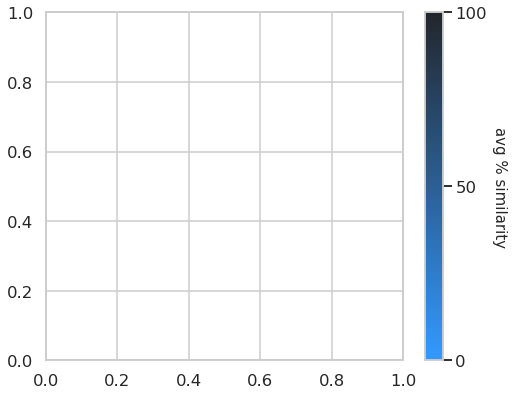

In [19]:
plot_scatter_perc(sequence_scores, foldseek_sequence_scores,  "sequence", "foldsek_sequence ", metric = "sp", title = "references in homfam", hue_var = "sim")

## Does combining foldseek and sequence improve performance? 

In [ ]:
plot_scatter_perc(foldseek_scores,foldseek_sequence_scores, "SoP of MSA-3D_foldseek ", "SoP of MSA-3D_foldseek+sequence",metric = "sp", title = "references in homfam")

In [ ]:
plot_scatter_perc(tmalign_scores, tmalign_sequence_scores,  "tmalign", "tmalign_sequence", metric = "sp", title = "references in homfam", hue_var = "sim")

In [ ]:
plot_categories(tmalign_scores, tmalign_sequence_scores, categories,  "tmalign", "tmalign_sequence", metric = "sp")

In [ ]:
plot_scatter_perc(sap_scores, sap_sequence_scores,  "sap_scores", "sap_sequence_scores", metric = "tc", title = "references in homfam", hue_var = "sim")

## How do we do compared to standard 3D coffee? 

In [ ]:
plot_scatter_perc(tmalign_sequence_scores,foldseek_sequence_scores, "tmalign", "foldseek_sequence",metric = "sp", title = "references in homfam")

In [ ]:
plot_categories(tmalign_sequence_scores,foldseek_sequence_scores,categories, "tmalign", "foldseek_sequence",metric = "sp")

In [ ]:
plot_scatter_perc(tmalign_sequence_scores, sequence_scores, "tmalign_sequence", "sequence", metric = "sp", title = "references in homfam")

# Test that the new t_coffee implementation works 

In [ ]:
# 1. TCOFFEE  
#sequence_scores = get_scores(glob.glob(os.path.join(data_dir, "evaluation/score/*progressive.PROBAPAIR.MBED*")))
fs_scores = get_scores(glob.glob(os.path.join(data_dir, "evaluation/score/*fs_sequence*")))
fs_scores[["family", "tree_method","library_method"]] = fs_scores.name.str.split(".", expand = True)
fs_scores = pd.merge(fs_scores, families, on = "family")

fs_only = get_scores(glob.glob(os.path.join(data_dir, "evaluation/score/*fs_only*")))
fs_only[["family", "tree_method","library_method"]] = fs_only.name.str.split(".", expand = True)
fs_only = pd.merge(fs_only, families, on = "family")

proba_only = get_scores(glob.glob(os.path.join(data_dir, "evaluation/score/*proba_only*")))
proba_only[["family", "tree_method","library_method"]] = proba_only.name.str.split(".", expand = True)
proba_only = pd.merge(proba_only, families, on = "family")

In [ ]:
plot_scatter_perc(proba_only, fs_scores, "proba_only", "fs_scores", metric = "sp", title = "references in homfam")
plot_scatter_perc(foldseek_sequence_scores, fs_scores, "pre-lib comp", "tcoffe integrated", metric = "sp", title = "references in homfam")
plot_scatter_perc(fs_only ,fs_scores, "fs_only", "fs_scores", metric = "sp", title = "references in homfam")

In [ ]:
plot_scatter_perc(foldseek_sequence_scores, fs_scores, "pre-lib comp", "tcoffe integrated", metric = "sp", title = "references in homfam")


In [ ]:
df = pd.merge(foldseek_sequence_scores,fs_scores, on = "family", suffixes = ("_precomp", "_tcoffee"))
df["diff"] = df.sp_tcoffee - df.sp_precomp
df[df["diff"] < 0].sort_values("diff")

In [ ]:

a = df[df.family == "seatoxin-ref"][["family", "sp_precomp", "tc_precomp", "sp_tcoffee", "tc_tcoffee"]]
a.to_csv("/home/luisasantus/Desktop/example_libraries/stats.txt", index = False, header = True)

In [ ]:
plot_scatter_perc(proba_only, fs_scores, "proba_only", "fs_scores", metric = "sp", title = "references in homfam")